In [ ]:
#Required packages
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler
cmd='pip install plot-keras-history==1.1.30'
import os
os.system(cmd)
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

#fixed seed
np.random.seed(0)

#pre-processing of the data

pulsarfile= open('/content/data.txt','r')
pulsardata = pulsarfile.read()
data=pulsardata.splitlines()
features=data[0].split(',')


for i in range(len(data)):
  
  data[i]=data[i].split(',')

  if i>=1:

    for j in range(len(data[i])):

      data[i][j]=float(data[i][j])

df = pd.DataFrame(data[1:],columns=features).astype(float)

inp=df.loc[:,' Mean of the integrated profile':' Skewness of the DM-SNR curve' ]
out=df.loc[:,features[-1]]


In [ ]:
#splitting of the data set into a test set and a training set
train_size=0.8
test_size=1-train_size

#print(out)
X_train, X_test, Y_train, Y_test = train_test_split(inp, out, train_size=train_size, test_size=test_size)

#handling of unbalanced data 
Y=np.unique(Y_train)
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=Y , y=Y_train)
class_weights = dict(enumerate(class_weights)),
print(class_weights)

#OneHot encoded vector
Y_train=to_categorical(Y_train, num_classes=2)
Y_test=to_categorical(Y_test, num_classes=2)

#scaling of the data
sc=StandardScaler()
scaler = sc.fit(X_train)
trainX_scaled = scaler.transform(X_train)
testX_scaled = scaler.transform(X_test)


3055     0.0
10138    0.0
3600     1.0
16245    0.0
6079     0.0
        ... 
9225     1.0
13123    0.0
9845     0.0
10799    0.0
2732     0.0
Name: target_class, Length: 14318, dtype: float64
3580
({0: 0.552690496410098, 1: 5.244688644688645},)
3580
14318


# Model and Fit


In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential     
from tensorflow.keras.layers import Dense, Dropout           
from tensorflow.keras import optimizers             
from tensorflow.keras import regularizers           

#creation of the model
neurons_layer1 = 20
neurons_layer2 = 20

neurons_layer3=40
n_categories = 2

#Study made on the number of epochs and the batch size
#epochs=np.arange(10,150,10)
#batch_size=np.arange(10,200,20) 

epochs = 150
batch_size = 30
eta_values = np.logspace(-6, 1, 7)
lmbd_values = np.logspace(-6, 1, 7)
def neural_network(neurons_layer1,neurons_layer2,neurons_layer3, n_categories, eta, lmbd):
    model = Sequential()
    model.add(Dense(neurons_layer1, activation='sigmoid', kernel_regularizer=regularizers.l2(lmbd)))
    model.add(Dense(neurons_layer2, activation='sigmoid', kernel_regularizer=regularizers.l2(lmbd)))
    model.add(Dense(neurons_layer2, activation='sigmoid', kernel_regularizer=regularizers.l2(lmbd)))
    model.add(Dense(neurons_layer2, activation='sigmoid', kernel_regularizer=regularizers.l2(lmbd)))
    model.add(Dense(neurons_layer3, activation='sigmoid', kernel_regularizer=regularizers.l2(lmbd)))
    model.add(Dense(neurons_layer3, activation='sigmoid', kernel_regularizer=regularizers.l2(lmbd)))
    model.add(Dropout(0.4))
    model.add(Dense(neurons_layer3, activation='sigmoid', kernel_regularizer=regularizers.l2(lmbd)))
    model.add(Dense(n_categories, activation='sigmoid'))
    
    sgd = optimizers.Adam(lr=eta)
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
    return model


In [ ]:
Network_keras=np.zeros((len(eta_values),len(lmbd_values)),dtype=object)
#Looking for the best set of hyperparameters
for i, eta in enumerate(eta_values):
    for j, lmbd in enumerate(lmbd_values):
        Network = neural_network(neurons_layer1, neurons_layer2, neurons_layer2, n_categories,
                                         eta=eta, lmbd=lmbd)
        Network.fit(trainX_scaled, Y_train, epochs=epochs, batch_size=batch_size, verbose=0,class_weight=class_weights[0])
        scores = Network.evaluate(testX_scaled, Y_test)
        
        Network_keras[i][j] = Network
        
        print("Learning rate = ", eta)
        print("lambda = ", lmbd)
        print("Test accuracy: %.3f" % scores[1])
        print("Test loss: %.3f" % scores[0])


In [ ]:
Network = neural_network(neurons_layer1,neurons_layer2, neurons_layer2, n_categories,
                                        eta=0.001, lmbd=0.0001)
history = Network.fit(trainX_scaled, Y_train,batch_size=batch_size,epochs=epochs, verbose=1,class_weight=class_weights[0])
show_history(history)
plot_history(history, path="standard.png")
plt.close()

In [ ]:
 scores = Network.evaluate(testX_scaled, Y_test)
 scores


112/112 [==============================] - 1s 2ms/step - loss: 0.1030 - accuracy: 0.9799


[0.10301618278026581, 0.9798882603645325]

In [ ]:
#summary of the model 
Network.summary()

Model: "sequential_68"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_544 (Dense)           (None, 20)                180       
                                                                 
 dense_545 (Dense)           (None, 20)                420       
                                                                 
 dense_546 (Dense)           (None, 20)                420       
                                                                 
 dense_547 (Dense)           (None, 20)                420       
                                                                 
 dense_548 (Dense)           (None, 20)                420       
                                                                 
 dense_549 (Dense)           (None, 20)                420       
                                                                 
 dense_550 (Dense)           (None, 20)              

112/112 [==============================] - 0s 2ms/step - loss: 17721.4766 - accuracy: 0.0765


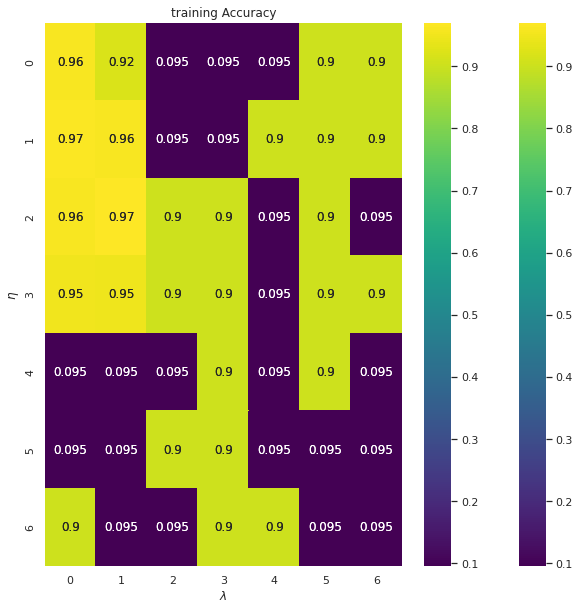

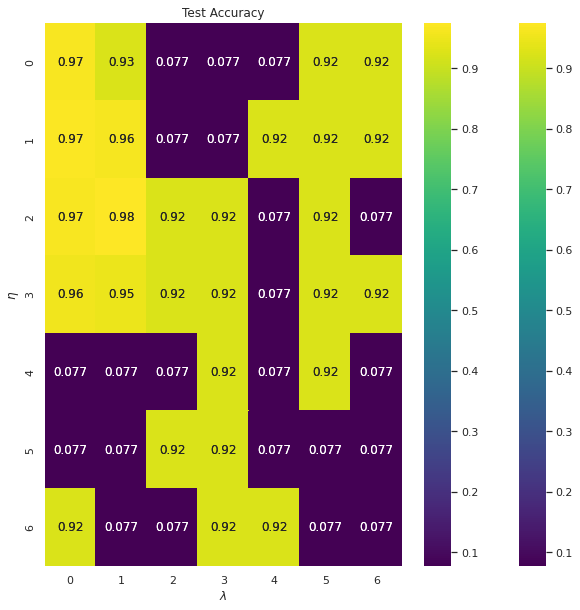

In [ ]:
#Looking at the grid search
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

train_accuracy = np.zeros((len(eta_values), len(lmbd_values)))
test_accuracy = np.zeros((len(eta_values), len(lmbd_values)))

for i in range(len(eta_values)):
    for j in range(len(lmbd_values)):
        Network = Network_keras[i][j]

        train_accuracy[i][j] = Network.evaluate(trainX_scaled, Y_train)[1]
        test_accuracy[i][j] = Network.evaluate(testX_scaled, Y_test)[1]

      
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
ax.set_title("Training Accuracy")

plt.plot(heatmap2=sns.heatmap(train_accuracy, annot=True, ax=ax, cmap="viridis"))
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
ax.set_title("Training Accuracy")

plt.savefig("/content/training_accuracy1.png")

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Test Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.plot(heatmap3=sns.heatmap(test_accuracy, annot=True, ax=ax, cmap="viridis"))
ax.set_title("Test Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.savefig("/content/test_accuracy1.png")

In [ ]:
from sklearn.metrics import confusion_matrix
#Network_keras=np.zeros((len(batch_size)),dtype=object)
j=0
eta=0.01
lmbd=0.00001
for i in batch_size:
      Network = neural_network(neurons_layer1, neurons_layer2, n_categories, 
                                eta=0.01, lmbd=0.00001)

      Network.fit(trainX_scaled, Y_train, epochs=epochs, batch_size=i, verbose=0, class_weight=class_weights[0])
      scores = Network.evaluate(testX_scaled, Y_test)
        
     # Network_keras[j] = Network
      j+=1
        
      print("Learning rate = ", eta)
      print("lambda = ", lmbd)
      print("Test accuracy: %.3f" % scores[1])
      print("Test loss: %.3f" % scores[0])
      predicted= Network.predict(testX_scaled)
      predicted=np.argmax(predicted, axis=1)
      Y_test2=np.argmax(Y_test, axis=1)
      cm = confusion_matrix(Y_test2,predicted)
      print(cm)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


112/112 [==============================] - 0s 2ms/step - loss: 0.1472 - accuracy: 0.9631
Learning rate =  0.01
lambda =  1e-05
Test accuracy: 0.963
Test loss: 0.147
[[3193  113]
 [  19  255]]


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


112/112 [==============================] - 0s 2ms/step - loss: 0.1875 - accuracy: 0.9606
Learning rate =  0.01
lambda =  1e-05
Test accuracy: 0.961
Test loss: 0.187
[[3185  121]
 [  20  254]]


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


112/112 [==============================] - 0s 2ms/step - loss: 0.1349 - accuracy: 0.9715
Learning rate =  0.01
lambda =  1e-05
Test accuracy: 0.972
Test loss: 0.135
[[3225   81]
 [  21  253]]


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


112/112 [==============================] - 0s 2ms/step - loss: 0.1117 - accuracy: 0.9779
Learning rate =  0.01
lambda =  1e-05
Test accuracy: 0.978
Test loss: 0.112
[[3248   58]
 [  21  253]]


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


112/112 [==============================] - 0s 2ms/step - loss: 0.1315 - accuracy: 0.9788
Learning rate =  0.01
lambda =  1e-05
Test accuracy: 0.979
Test loss: 0.131
[[3252   54]
 [  22  252]]


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


112/112 [==============================] - 0s 2ms/step - loss: 0.1625 - accuracy: 0.9662
Learning rate =  0.01
lambda =  1e-05
Test accuracy: 0.966
Test loss: 0.162
[[3204  102]
 [  19  255]]


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


112/112 [==============================] - 0s 2ms/step - loss: 0.1690 - accuracy: 0.9564
Learning rate =  0.01
lambda =  1e-05
Test accuracy: 0.956
Test loss: 0.169
[[3169  137]
 [  19  255]]


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


112/112 [==============================] - 0s 2ms/step - loss: 0.1574 - accuracy: 0.9609
Learning rate =  0.01
lambda =  1e-05
Test accuracy: 0.961
Test loss: 0.157
[[3185  121]
 [  19  255]]


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


112/112 [==============================] - 0s 2ms/step - loss: 0.1200 - accuracy: 0.9746
Learning rate =  0.01
lambda =  1e-05
Test accuracy: 0.975
Test loss: 0.120
[[3235   71]
 [  20  254]]


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


112/112 [==============================] - 0s 2ms/step - loss: 0.1510 - accuracy: 0.9645
Learning rate =  0.01
lambda =  1e-05
Test accuracy: 0.965
Test loss: 0.151
[[3198  108]
 [  19  255]]


# Bin


In [ ]:

import pandas as pd

df = pd.DataFrame(data[1:],columns=features).astype(float)
#print(df)
inp=df.loc[:,' Mean of the integrated profile':' Skewness of the DM-SNR curve' ]
out=df.loc[:,features[-1]]
#print(out)
#print(in2)
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
train_size=0.75
test_size=1-train_size
out=to_categorical(out)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
inp = scaler.fit_transform(inp)
X_train, X_test, Y_train, Y_test = train_test_split(inp, out, train_size=train_size, test_size=test_size)
print(inp)

[[ 1.14931702  1.33483164 -0.66956953 ... -0.37062547 -0.07279778
  -0.28743812]
 [-0.3341682   1.80226533 -0.01178476 ... -0.5889241   0.50442694
   0.21158145]
 [-0.31437216 -1.05332222 -0.14523256 ... -0.23532816 -0.12599609
  -0.39137346]
 ...
 [ 0.3218423   1.95621968 -0.2993338  ...  1.67156847 -1.28807874
  -0.94133005]
 [ 0.13362759  1.07450972 -0.26005007 ... -0.66485697  0.37825656
   0.27584987]
 [-2.10576204  5.73546965  0.87267394 ...  1.97154554 -2.19732744
  -0.97105168]]
